# Setup COLAB and imports

In [ ]:
''' Used to reference the root directory, for directory traversal '''
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = '/content/gdrive/My Drive/Colab Notebooks'

Mounted at /content/gdrive


In [ ]:
! pip install rasterio

In [ ]:
import rasterio
from rasterio.plot import show, reshape_as_raster, reshape_as_image

from matplotlib import pyplot as plt
%matplotlib inline

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm 
import tensorflow as tf
import copy

# Global

In [ ]:
''' get the same random set every time '''
seed = 42
np.random.seed = seed


''' we will be resizing to this for the unet '''
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
DTYPE_TARGET = np.uint16


''' setting the amount of data we want to use '''
SIZE_TRAIN = 3401  
SIZE_TEST = 401  

In [ ]:
''' change in accordance to the image type and dimensions '''
COMBI = 'pan_256x256_uint16'


''' Set the original data source '''
PATH_SRC = Path(root_dir + '/spacenet6/spacenet6_data_BACKUP/train_all/AOI_11_Rotterdam')
PATH_SRC_IMAGE = PATH_SRC/'PAN'
PATH_SRC_MASK = PATH_SRC/'_mask'


''' Create a new directory for this specific resize combination '''
PATH_DATA = Path(root_dir + '/spacenet6/spacenet6_data/' + COMBI)
PATH_DATA.mkdir(parents=True, exist_ok=True)

PATH_TRAIN = PATH_DATA/'train'
PATH_TRAIN.mkdir(parents=True, exist_ok=True)

PATH_MASK = PATH_DATA/'mask'
PATH_MASK.mkdir(parents=True, exist_ok=True)

PATH_TEST = PATH_DATA/'test'
PATH_TEST.mkdir(parents=True, exist_ok=True)

# Helper functions

### Available functions
*   resize(raster)
*   resize_and_save(fname, path_src, path_save)

### Resize a raster to a smaller size for training. Make sure it is power of 2

In [ ]:
''' images read by rasterio as (band, height, width), but giving to unet as (height, width, band) by reshape_as_image ''' 
def resize(raster):
  img = reshape_as_image(raster)
  img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH], preserve_aspect_ratio=True, method='nearest')
  raster = reshape_as_raster(img)
  return raster

### Triggers resize(raster), then saves it 

In [ ]:
def resize_and_save(fname, path_src, path_save):
  img = rasterio.open(path_src/fname)

  # resize the image
  clipped = resize(img.read())

  # use the metadata from the original image
  transform = img.transform
  meta = img.meta.copy()

  # update metadata with new size
  meta.update({"transform": transform,
              "height": clipped.shape[1],
              "width": clipped.shape[2]
              })

  # write the clipped-and-cropped data to a new geotiff
  with rasterio.open(path_save/fname, 'w', **meta) as dst:
    dst.write(clipped)

# Resize

In [ ]:
# Grab the filenames from files that were prepared
train_ids = next(os.walk(PATH_SRC_IMAGE))[2]
train_ids.sort()
print('train_ids', len(train_ids))
print(train_ids[:3])

mask_ids = next(os.walk(PATH_SRC_MASK))[2]
mask_ids.sort()
print('mask_ids', len(mask_ids))
print(mask_ids[:3])

# set aside the last 401 images as test images (this is arbitrary)
test_ids = train_ids[-401:]
test_ids.sort()
print('test_ids', len(test_ids))
print(test_ids[:3])

train_ids 3401
['SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8683.tif']
mask_ids 3401
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif']
test_ids 401
['SN6_Train_AOI_11_Rotterdam_PAN_20190823141628_20190823141922_tile_8743.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190823141628_20190823141922_tile_8744.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190823142111_20190823142355_tile_3933.tif']


In [ ]:
''' resize and save all the images into destination folder '''
print('Resizing training images')
for n, id in tqdm(enumerate(train_ids), total=len(train_ids), position=0, leave=True):
  resize_and_save(id, PATH_SRC_IMAGE, PATH_TRAIN)
print('Finished resizing training images')


print('Resizing training masks')
for n, id in tqdm(enumerate(mask_ids), total=len(mask_ids), position=0, leave=True):
  resize_and_save(id, PATH_SRC_MASK, PATH_MASK)
print('Finished resizing training masks')


print('Resizing test images')
for n, id in tqdm(enumerate(test_ids), total=len(test_ids), position=0, leave=True):
  resize_and_save(id, PATH_SRC_IMAGE, PATH_TEST)
print('Finished resizing test images')

Resizing training images


  0%|          | 2/3401 [00:00<04:26, 12.73it/s]

Finished resizing training images
Resizing training masks


  0%|          | 1/401 [00:00<00:58,  6.88it/s]

Finished resizing training masks
Resizing test images


100%|██████████| 401/401 [00:31<00:00, 12.75it/s]

Finished resizing test images


# Inspect result

In [ ]:
# Grab the filenames from files that were prepared

''' Get all, sort, then take a subset and make a copy '''
_train_ids = next(os.walk(PATH_TRAIN))[2]
_mask_ids = next(os.walk(PATH_MASK))[2]
_test_ids = next(os.walk(PATH_TEST))[2]

_train_ids.sort()
_mask_ids.sort()
_test_ids.sort()

train_ids = copy.deepcopy(_train_ids[:SIZE_TRAIN])
mask_ids = copy.deepcopy(_mask_ids[:SIZE_TRAIN])
test_ids = copy.deepcopy(_test_ids[:SIZE_TEST]) 

print(len(train_ids))
print(train_ids[:3])
print(len(mask_ids))
print(mask_ids[:3])
print(len(test_ids))
print(test_ids[:3])

3401
['SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8683.tif']
3401
['SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8679.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8681.tif', 'SN6_Train_AOI_11_Rotterdam_Buildings_20190804111224_20190804111453_tile_8683.tif']
401
['SN6_Train_AOI_11_Rotterdam_PAN_20190823141628_20190823141922_tile_8743.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190823141628_20190823141922_tile_8744.tif', 'SN6_Train_AOI_11_Rotterdam_PAN_20190823142111_20190823142355_tile_3933.tif']


index: 2447
Training set


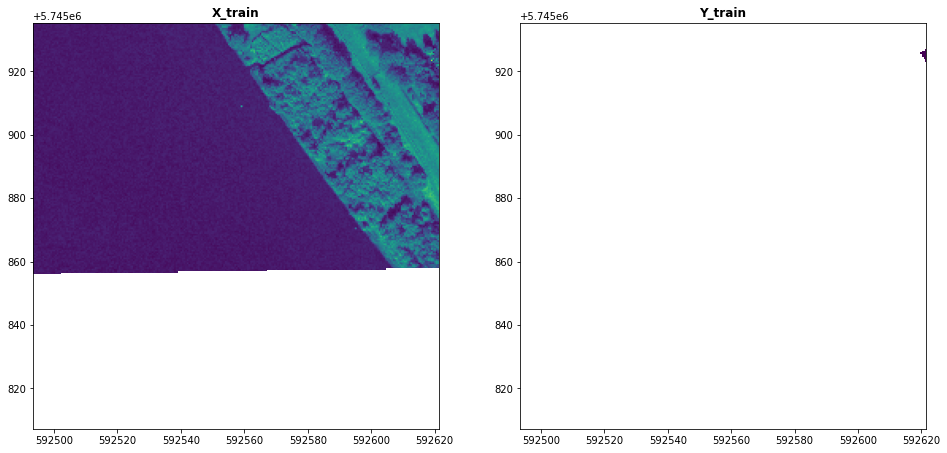

index: 2620
Training set


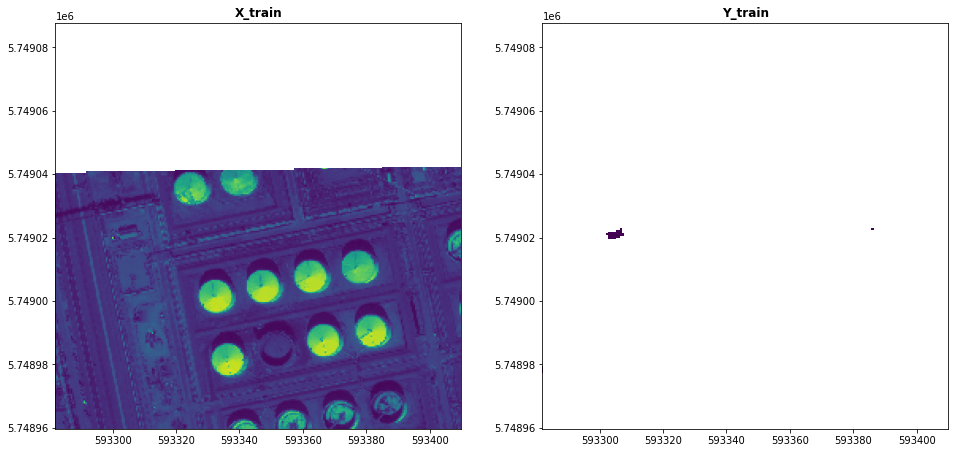

index: 18
Test set


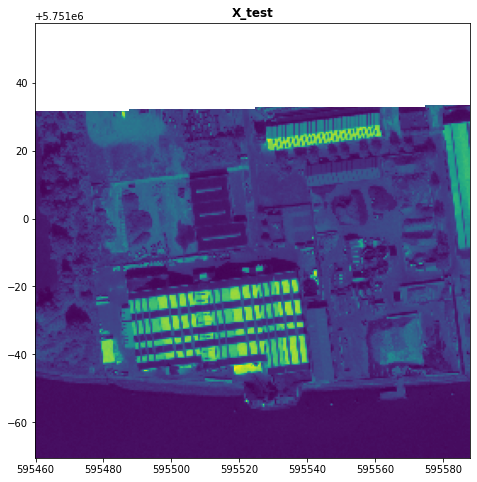

index: 166
Test set


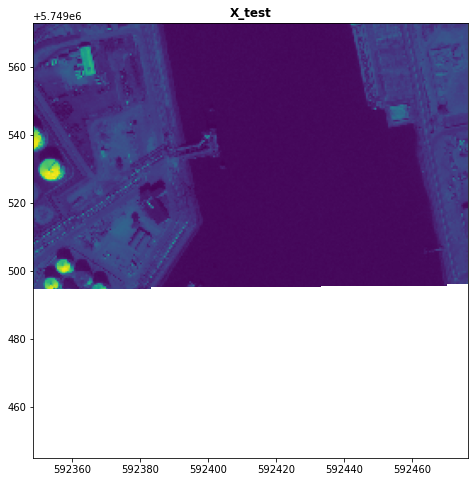

In [ ]:
ix = np.random.randint(0, len(train_ids))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(rasterio.open(PATH_TRAIN/train_ids[ix]), ax=ax1, title='X_train')
show(rasterio.open(PATH_MASK/mask_ids[ix]), ax=ax2, title='Y_train')
plt.show()



ix = np.random.randint(0, len(train_ids))
print("index: {}".format(ix))
print("Training set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
show(rasterio.open(PATH_TRAIN/train_ids[ix]), ax=ax1, title='X_train')
show(rasterio.open(PATH_MASK/mask_ids[ix]), ax=ax2, title='Y_train')
plt.show()



ix = np.random.randint(0, len(test_ids))
print("index: {}".format(ix))
print("Test set")

fig, (ax1) = plt.subplots(1, figsize=(16,8))
show(rasterio.open(PATH_TEST/test_ids[ix]), ax=ax1, title='X_test')
plt.show()



ix = np.random.randint(0, len(test_ids))
print("index: {}".format(ix))
print("Test set")

fig, (ax1) = plt.subplots(1, figsize=(16,8))
show(rasterio.open(PATH_TEST/test_ids[ix]), ax=ax1, title='X_test')
plt.show()